# DDPG

### Import Libraries 

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import copy
from itertools import count
import os
import warnings
warnings.filterwarnings("ignore")

### Set Up Environment

In [2]:
# Create the LunarLanderContinuous-v2 environment
env = gym.make("LunarLanderContinuous-v2")

# Reset the environment to get the initial observation and set the initial total reward to zero
obs, _ = env.reset()  
episode_reward = 0.0  

### Set Hyperparameters & Other Variables

In [3]:
# Define a namedtuple to store the experience tuples
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

# Define the Hyperparameters

# Discount factor for future rewards
GAMMA = 0.99  
# Number of samples per batch
BATCH_SIZE = 64  
# Maximum size of the replay buffer
BUFFER_SIZE = 10000  
# Minimum size of the replay buffer 
MIN_REPLAY_SIZE = 5000  
# Soft update parameter for the target network
TAU = 0.01  

# Define the Variables

# Standard deviation for the noise process
std_dev = 0.2
# Deque to store the last 50 episode rewards
returns = deque(maxlen=50)  
# List to store average rewards per episode
average_rewards = []  
# Threshold for considering the environment as solved
solved_reward = 195 

# Function to convert data to a PyTorch tensor (float)
T = lambda x: torch.as_tensor(x, dtype=torch.float32)  
# Function to convert data to a PyTorch tensor (integer)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)   

In [4]:
# Define the path for saving average score data
folder_path = 'average_scores_experiment_2/'

# Check if the directory for average scores exists
if not os.path.exists(folder_path):
    # If the directory does not exist, create it
    os.makedirs(folder_path)

### Define Ornstein-Uhlenbeck Noise for Exploration

In [5]:
# Base class for action noise, to be used in exploration strategies
class ActionNoise(object):
    def reset(self):
        pass  

# Implementation of Ornstein-Uhlenbeck process for adding noise to actions
class OrnsteinUhlenbeckActionNoise(ActionNoise):
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        # Speed of mean reversion
        self.theta = theta
        # Long-running mean
        self.mu = mu   
        # Volatility parameter
        self.sigma = sigma  
        # Time increment
        self.dt = dt  
        # Initial value for the process
        self.x0 = x0        
        self.reset()

    def __call__(self):
        # Compute the next sample of noise
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        # Reset the noise to its initial state or zero if not specified
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        # Representation of the noise parameters
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

# Create an instance of Ornstein-Uhlenbeck noise with specified parameters
ou_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=float(std_dev) * np.ones(1))

### Define Replay Memory

In [6]:
# Class for managing the replay memory
class Replay_memory():
    def __init__(self, env, fullsize, minsize, batchsize):
        # The Gym environment
        self.env = env                 
        # Memory buffer to store transitions with a fixed maximum size
        self.memory = deque(maxlen=fullsize)    
        # Batch size for sampling from the memory
        self.batchsize = batchsize   
        # Minimum size of memory before starting training
        self.minsize = minsize            

    def append(self, transition):
        # Add a transition to the memory buffer
        self.memory.append(transition)

    def sample_batch(self):
        # Sample a batch of transitions for training
        batch = random.sample(self.memory, self.batchsize)
        # Convert batch to Transition namedtuple format
        batch = Transition(*zip(*batch))  
        # Convert arrays to PyTorch tensors
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.float32))
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        # Populate the memory with minimum required samples before training
        obs, _ = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

# Initialize the replay memory with the specified environment and parameters
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

### Define Actor (Policy) and Critic Networks

In [7]:
# PolicyNet: Defines the actor network for generating actions based on states
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        # Minimum and maximum action values (used for clipping the output)
        self.pmin = pmin
        self.pmax = pmax
        # Define the neural network layers
        self.model = nn.Sequential(
            # Input layer 
            nn.Linear(input_size, hidden_units),  
            # Activation function
            nn.ReLU(),             
            # Hidden layer with half the units of the previous layer
            nn.Linear(hidden_units, int(hidden_units/2)),  
            # Activation function
            nn.ReLU(),  
            # Output layer with 'output_size' units
            nn.Linear(int(hidden_units/2), output_size),  
            # Activation function to scale the output
            nn.Tanh()                             
        )
    
    # Forward pass through the network
    def forward(self, x):
        # Scale the output by the maximum action value
        x = self.model(x) * self.pmax  
        # Clip the output to be within the specified range
        torch.clip_(x, self.pmin, self.pmax)  
        return x
    
# DQN (CriticNet): Defines the critic network for evaluating state-action pairs
class DQN(nn.Module):
    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        # Define the neural network layers
        self.model = nn.Sequential(
            # Input layer
            nn.Linear(input_size, hidden_units), 
            # Activation function
            nn.ReLU(),       
            # Hidden layer
            nn.Linear(hidden_units, int(hidden_units/2)),  
            # Activation function
            nn.ReLU(),                         
            # Output layer with a single unit
            nn.Linear(int(hidden_units/2), 1)     
        )
    
    # Forward pass for computing Q-values
    def forward(self, state, action):
        # Concatenate state and action as input
        x = torch.cat([state, action], 1)  
        # Pass the concatenated input through the network
        x = self.model(x) 
        return x

### Initialize Networks and Optimizers

In [8]:
# Determine the size of the observation and action spaces from the environment
obs_size = env.observation_space.shape[0]  
act_size = env.action_space.shape[0]       

# Define the number of hidden layers for the neural networks
hiddenlayers = 128

# Get the minimum and maximum range for actions from the environment
output_minrange = env.action_space.low     
output_maxrange = env.action_space.high    

# Initialize the actor network (PolicyNet) with the environment's dimensions and action range
actor = PolicyNet(obs_size, hiddenlayers, act_size, T(output_minrange), T(output_maxrange))

# Create a target actor network as a deep copy for stable training
actor_target = copy.deepcopy(actor)

# Initialize the critic network (DQN) with combined dimensions of state and action space
critic = DQN(obs_size + act_size, hiddenlayers)

# Create a target critic network as a deep copy for stable training
critic_target = copy.deepcopy(critic)

# Initialize optimizers for both actor and critic networks with specified learning rates
actor_optimizer = optim.AdamW(actor.parameters(), lr=0.0003)
critic_optimizer = optim.AdamW(critic.parameters(), lr=0.0003)

### Update Function

In [9]:
def update():
    # Sample a batch of experiences from the replay memory
    states, actions, rewards, dones, next_states = replay_memory.sample_batch()

    # Reset the Ornstein-Uhlenbeck noise for exploration
    ou_noise.reset()

    # Calculate the critic loss
    Qvals = critic(states, actions)  # Predict the current Q-values
    with torch.no_grad():
        # Predict next actions using the target actor network
        actions_ = actor_target(next_states)      
        # Predict next Q-values using the target critic network
        Qvals_ = critic_target(next_states, actions_)   
        # Set Q-values to 0 for terminal states
        Qvals_[dones] = 0.0                  
        # Compute the target Q-values
        target = rewards + GAMMA * Qvals_      
    # Compute the loss between target and current Q-values
    critic_loss = F.smooth_l1_loss(target, Qvals)       

    # Calculate the actor loss (negative mean of the critic's Q-values)
    actor_loss = -critic(states, actor(states)).mean()

    # Update the actor network
    # Zero the gradients
    actor_optimizer.zero_grad()  
    # Backpropagate the loss
    actor_loss.backward()  
    # Perform a step of optimization
    actor_optimizer.step()       

    # Update the critic network
    # Zero the gradients
    critic_optimizer.zero_grad()  
    # Backpropagate the loss
    critic_loss.backward() 
    # Perform a step of optimization
    critic_optimizer.step()       

    # Update the target networks
    for target_param, param in zip(actor_target.parameters(), actor.parameters()):
        # Update target actor network
        target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))  
    for target_param, param in zip(critic_target.parameters(), critic.parameters()):
        # Update target critic network
        target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))  

### Training Loop

In [10]:
# Training loop for each episode
for episode in count():
    # Reset the environment at the start of each episode
    state, _ = env.reset()
    # Initialize the reward for the current episode
    episode_reward = 0  
    # Flag to track if the episode is finished
    done = False       

    # Loop until the episode ends
    while not done:
        with torch.no_grad():
            # Get action from the actor network plus some noise for exploration
            action = actor(T(state)).numpy() + ou_noise()
        # Apply the action to the environment and observe the next state and reward
        new_state, reward, terminated, truncated, _ = env.step(action)
        # Check if the episode has ended
        done = terminated or truncated  
        # Create a transition tuple for the experience
        transition = Transition(state, action, reward, done, new_state)
        # Store the transition in replay memory
        replay_memory.append(transition)
        # Update the networks
        update()
        # Update the state for the next iteration
        state = new_state
        # Accumulate the reward
        episode_reward += reward

    # Store the total reward of the episode
    returns.append(episode_reward)
    average_rewards.append(episode_reward)
    
    # Print the reward every 10 episodes and the average of the last 10 episodes
    if episode % 10 == 0:
        # Calculate average of the last 10 episode rewards
        last_10_avg_reward = np.mean(average_rewards[-10:])  
        print(f'Episode: {episode}  Reward: {episode_reward}  Average Reward (Last 10 Episodes): {last_10_avg_reward}')

    # Check if the problem is solved (average reward over last 50 episodes >= solved_reward)
    if len(returns) == 50:
        avg_reward = np.mean(returns)
        if avg_reward >= solved_reward:
            # Print a message if the environment is considered solved
            print("*" * 125)
            print(f'Solved! Episode: {episode}, Average Score Last 50 Episodes: {avg_reward}')
            print("*" * 125)
            # Break the loop if the environment is solved
            break

# Save average reward to file
np.save(folder_path + 'average_scores_deterministic.npy', np.array(average_rewards))

# Close the environment after training
env.close()

Episode: 0  Reward: -92.14185303519713  Average Reward (Last 10 Episodes): -92.14185303519713
Episode: 10  Reward: -57.13933618644114  Average Reward (Last 10 Episodes): -147.596421189685
Episode: 20  Reward: -188.72736158061565  Average Reward (Last 10 Episodes): -133.53293618743368
Episode: 30  Reward: -47.93701079714593  Average Reward (Last 10 Episodes): -104.95063778526121
Episode: 40  Reward: -89.16870077274595  Average Reward (Last 10 Episodes): -94.75784714534517
Episode: 50  Reward: -127.09242878684411  Average Reward (Last 10 Episodes): -121.73341909749702
Episode: 60  Reward: -12.020277357110581  Average Reward (Last 10 Episodes): -131.62890955327148
Episode: 70  Reward: -48.78408085934217  Average Reward (Last 10 Episodes): -67.88881389714672
Episode: 80  Reward: 40.04999472246962  Average Reward (Last 10 Episodes): -32.118486729790696
Episode: 90  Reward: 5.095394423564429  Average Reward (Last 10 Episodes): 14.387083615828425
Episode: 100  Reward: -116.93893186387066  Ave

### Visualisation

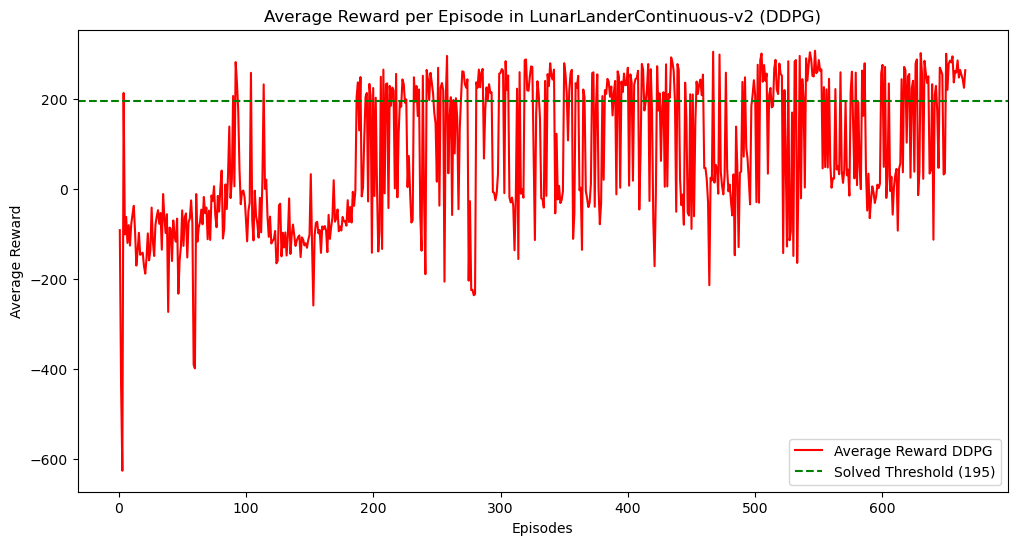

In [11]:
# Creating the plot for DDPG

# Assuming average_rewards contains the average reward for each episode
episode_numbers = list(range(1, len(average_rewards) + 1))

plt.figure(figsize=(12, 6))

# Plot average rewards per episode
plt.plot(episode_numbers, average_rewards, label='Average Reward DDPG', color='red')

# Add a horizontal line representing the solved threshold
plt.axhline(y=solved_reward, color='green', linestyle='--', label='Solved Threshold (195)')

# Set labels for x and y axes
plt.xlabel('Episodes')
plt.ylabel('Average Reward')

# Display the plot
plt.title('Average Reward per Episode in LunarLanderContinuous-v2 (DDPG)')
plt.legend()
plt.show()